In [1]:
import pandas as pd
import numpy as np


def load_tweets():
    return pd.read_csv('customer-support-on-twitter/twcs.zip', index_col=0)


tweets = load_tweets()

/opt/devhome/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
tweets.head(1202).tail(6)

,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
tweet_id,,,,,,
1786,AppleSupport,False,Tue Oct 31 22:30:01 +0000 2017,@116107 Glad to hear and just reach out again ...,NaN,1787.0
1787,116107,True,Tue Oct 31 22:10:27 +0000 2017,@AppleSupport Worked 👌🏽,1786,1788.0
1788,AppleSupport,False,Tue Oct 31 21:46:54 +0000 2017,@116107 Please keep us posted afterwards.,1787,1789.0
1789,116107,True,Tue Oct 31 21:32:24 +0000 2017,@AppleSupport No I had 11.0.3 but now it says ...,1788,1790.0
1790,AppleSupport,False,Tue Oct 31 21:30:00 +0000 2017,@116107 Apps are important and we want you to ...,1789,1791.0
1791,116107,True,Tue Oct 31 21:25:20 +0000 2017,why won’t my apps fuccin download or update @A...,1790,NaN


In [3]:
tweets.loc[tweets['inbound']==False]['author_id'].unique()

array(['sprintcare', 'Ask_Spectrum', 'VerizonSupport', 'ChipotleTweets',
       'AskPlayStation', 'marksandspencer', 'MicrosoftHelps', 'ATVIAssist',
       'AdobeCare', 'AmazonHelp', 'XboxSupport', 'AirbnbHelp',
       'nationalrailenq', 'AirAsiaSupport', 'Morrisons', 'NikeSupport',
       'AskAmex', 'McDonalds', 'YahooCare', 'AskLyft', 'UPSHelp', 'Delta',
       'AppleSupport', 'Uber_Support', 'Tesco', 'SpotifyCares',
       'British_Airways', 'comcastcares', 'AmericanAir', 'TMobileHelp',
       'VirginTrains', 'SouthwestAir', 'AskeBay', 'hulu_support',
       'GWRHelp', 'sainsburys', 'AskPayPal', 'HPSupport', 'ChaseSupport',
       'CoxHelp', 'DropboxSupport', 'VirginAtlantic', 'BofA_Help',
       'AzureSupport', 'AlaskaAir', 'ArgosHelpers', 'Postmates_Help',
       'AskTarget', 'GoDaddyHelp', 'CenturyLinkHelp', 'AskPapaJohns',
       'SW_Help', 'askpanera', 'Walmart', 'USCellularCares',
       'AsurionCares', 'GloCare', 'idea_cares', 'DoorDash_Help',
       'NeweggService', 'VirginA

In [4]:
# Pick only inbound tweets that aren't in reply to anything...
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]
print('Found {} first inbound messages.'.format(len(first_inbound)))

# Merge in all tweets in response
#inbounds_and_outbounds = pd.merge(first_inbound, tweets, left_on='tweet_id', 
#                                  right_on='in_response_to_tweet_id')
#print("Found {} responses.".format(len(inbounds_and_outbounds)))

inbounds_and_outbounds = pd.merge(first_inbound, tweets, left_index=True, 
                                  right_on='in_response_to_tweet_id')


# Filter out cases where reply tweet isn't from company
inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]
inbounds_and_outbounds[inbounds_and_outbounds.author_id_y=='Walmart'][:6]

Found 787346 first inbound messages.


,in_response_to_tweet_id,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
tweet_id,,,,,,,,,,,,,
2378,2380,116254,True,Tue Oct 31 21:53:32 +0000 2017,Just got recognized at @Walmart as the guy who...,2378,NaN,Walmart,False,Tue Oct 31 22:39:02 +0000 2017,"@116254 We disagree, Dylan. We're excited that...",2379,2380
2383,2384,116256,True,Sun Oct 29 05:03:21 +0000 2017,we all know walmart is better in terms of a lo...,2383,NaN,Walmart,False,Sun Oct 29 14:16:20 +0000 2017,"@116256 We ❤️ you too, Angel. Thanks for havin...",2382,2384
2390,2391,116259,True,Tue Oct 31 19:01:20 +0000 2017,It isn’t every day you get 3 carts full of bla...,2390,NaN,Walmart,False,Tue Oct 31 22:08:18 +0000 2017,@116259 We love it! Sounds like a double win! ...,NaN,2391
2392,2393,116260,True,Tue Oct 31 20:34:57 +0000 2017,Used @Walmart #grocerypickup and it's a pretty...,2392,NaN,Walmart,False,Tue Oct 31 22:00:57 +0000 2017,@116260 Yay! We're thrilled to hear you've enj...,NaN,2393
2394,2395,116261,True,Tue Oct 31 20:45:49 +0000 2017,Everybody I’ve met at Walmart is so friendly! ...,2394,NaN,Walmart,False,Tue Oct 31 21:53:49 +0000 2017,@116261 We want you to leave our store with a ...,NaN,2395
2398,2399,116262,True,Tue Oct 31 17:10:30 +0000 2017,Happy Halloween! Look at these pumpkins that w...,2398,NaN,Walmart,False,Tue Oct 31 17:34:28 +0000 2017,@116262 Nothing but the best for the communiti...,2397,2399


In [5]:
sorted_answerers=inbounds_and_outbounds.groupby('author_id_y').size().sort_values()
sorted_answerers_sum = sorted_answerers.values.sum()
sorted_answerers_sum_percent=sorted_answerers/sorted_answerers_sum*100.0

In [6]:
sorted_answerers_sum_percent[-20:]

author_id_y
sainsburys          1.355031
AskPlayStation      1.434850
XboxSupport         1.574848
sprintcare          1.592473
ChipotleTweets      1.744054
hulu_support        1.786984
UPSHelp             1.799448
VirginTrains        1.807506
Ask_Spectrum        2.174244
British_Airways     2.468969
TMobileHelp         2.526127
SouthwestAir        2.642078
comcastcares        3.001515
AmericanAir         3.085236
Tesco               3.133203
SpotifyCares        3.391670
Delta               3.586181
Uber_Support        5.039538
AppleSupport        9.395958
AmazonHelp         10.655559
dtype: float64

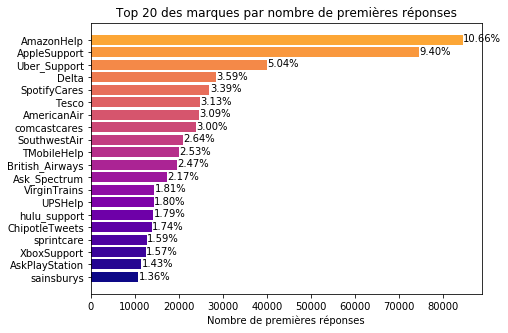

In [7]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
pos=np.arange(20)+0.5
plt.figure(figsize=(7,5))
ax = plt.subplot(111)
colors = cm.plasma_r(np.linspace(1,.2, 20))
plt.barh(pos,sorted_answerers.values[-20:],color=colors, tick_label=sorted_answerers.keys()[-20:])
plt.yticks(pos,sorted_answerers.keys()[-20:])
plt.xlabel('Nombre de premières réponses')
plt.title('Top 20 des marques par nombre de premières réponses')
for i, v in enumerate(sorted_answerers.values[-20:]):
    ax.text(v + 100, i + .35, "{:.2f}%".format(sorted_answerers_sum_percent[-20:][i]))

plt.show()

In [8]:
def all_tweets_to(tweets, author_id):
    return tweets.loc[pd.unique(tweets.loc[(tweets['inbound']==False) & (tweets['author_id'] == author_id)]['in_response_to_tweet_id'])]

def all_initial_tweets_to(tweets, author_id):
    return tweets[(tweets.text.str.contains(author_id)) & (tweets.in_response_to_tweet_id.isnull())]

In [9]:
#all_initial_tweets_to(tweets,'@OfficeSupport')
inbounds_and_outbounds[inbounds_and_outbounds.author_id_y=='Walmart'][:6]

,in_response_to_tweet_id,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
tweet_id,,,,,,,,,,,,,
2378,2380,116254,True,Tue Oct 31 21:53:32 +0000 2017,Just got recognized at @Walmart as the guy who...,2378,NaN,Walmart,False,Tue Oct 31 22:39:02 +0000 2017,"@116254 We disagree, Dylan. We're excited that...",2379,2380
2383,2384,116256,True,Sun Oct 29 05:03:21 +0000 2017,we all know walmart is better in terms of a lo...,2383,NaN,Walmart,False,Sun Oct 29 14:16:20 +0000 2017,"@116256 We ❤️ you too, Angel. Thanks for havin...",2382,2384
2390,2391,116259,True,Tue Oct 31 19:01:20 +0000 2017,It isn’t every day you get 3 carts full of bla...,2390,NaN,Walmart,False,Tue Oct 31 22:08:18 +0000 2017,@116259 We love it! Sounds like a double win! ...,NaN,2391
2392,2393,116260,True,Tue Oct 31 20:34:57 +0000 2017,Used @Walmart #grocerypickup and it's a pretty...,2392,NaN,Walmart,False,Tue Oct 31 22:00:57 +0000 2017,@116260 Yay! We're thrilled to hear you've enj...,NaN,2393
2394,2395,116261,True,Tue Oct 31 20:45:49 +0000 2017,Everybody I’ve met at Walmart is so friendly! ...,2394,NaN,Walmart,False,Tue Oct 31 21:53:49 +0000 2017,@116261 We want you to leave our store with a ...,NaN,2395
2398,2399,116262,True,Tue Oct 31 17:10:30 +0000 2017,Happy Halloween! Look at these pumpkins that w...,2398,NaN,Walmart,False,Tue Oct 31 17:34:28 +0000 2017,@116262 Nothing but the best for the communiti...,2397,2399


In [10]:
#tutu = all_tweets_to(tweets,'@Walmart')
#tweets[(tweets.text.str.contains('@Walmart')) & (tweets.in_response_to_tweet_id.isnull())].text.count()
# apple = tweets[(tweets.text.str.contains('@AppleSupport')) & (tweets.in_response_to_tweet_id.isnull())].text
#apple = all_initial_tweets_to(tweets, '@AppleSupport')

#print(apple.loc[765].text)
#print(apple.loc[733].text)
#print(apple.loc[2987723].text)

    

In [11]:
apple = inbounds_and_outbounds[inbounds_and_outbounds.author_id_y=='AppleSupport']
print(apple.iloc[2].text_x)
print(apple.iloc[3].text_x)
print(apple.iloc[5].text_x)

@115858 @AppleSupport hello are all the lines closed for tonight #help
Hello, internet. Can someone explain why this symbol keeps appearing on my phone and when I️ try to type the letter I️? Also @AppleSupport https://t.co/QKwvTLtiN7
Thank you @AppleSupport I updated my phone and now it is even slower and barely works. Thank you for ruining my phone.😤


In [12]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from nltk.stem import WordNetLemmatizer
#import nltk
#nltk.download()
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer('english')

tknzr = TweetTokenizer(preserve_case=False)

def preprocess_tweet(tweet):
    #import string
    #tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '<url>', tweet)  # URLs
    #tweet = re.sub(r'(?:@[\d]+)', '<user>', tweet)  # numeric user-mentions
    #tweet = re.sub(r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)', '<hashtag>', tweet)  # hashtags
    #tweet = re.sub(r'(?:(?:\d+,?)+(?:\.?\d+)?)', '<number>', tweet)  # numbers
    
   # translate_table = dict((ord(char), None) for char in string.punctuation)   
    
    #return tweet.translate(translate_table)
    #return tweet
    #return " ".join([snowball_stemmer.stem(word) for word in tweet.split(" ")])
    return " ".join([wordnet_lemmatizer.lemmatize(word) for word in tweet.lower().split(" ")])


vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10000,stop_words='english', tokenizer=None, preprocessor=preprocess_tweet)

X = vectorizer.fit_transform(apple.text_x)
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 74632, n_features: 10000


In [13]:
# le but de cette cellule est de tuner la tokenisation

# 2 3 ou 5
test_text = apple.iloc[5].text_x
print(test_text)
print(tknzr.tokenize(test_text))

token_pattern = re.compile(r"(?u)\b\w\w+\b")
print(token_pattern.findall(test_text))

#token_pattern = re.compile(r"(?u)"+ url_regex+"|(?:(?:\b\w|\B[@#])\w+\b)")


url_regex = '(?:http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+)|\b\w+'
tweet_regex=r"(?u)"+ url_regex+"|(?:(?:\w|[@#])\w+)"
token_pattern = re.compile(tweet_regex)
print(token_pattern.findall(test_text))

Thank you @AppleSupport I updated my phone and now it is even slower and barely works. Thank you for ruining my phone.😤
['thank', 'you', '@applesupport', 'i', 'updated', 'my', 'phone', 'and', 'now', 'it', 'is', 'even', 'slower', 'and', 'barely', 'works', '.', 'thank', 'you', 'for', 'ruining', 'my', 'phone', '.', '😤']
['Thank', 'you', 'AppleSupport', 'updated', 'my', 'phone', 'and', 'now', 'it', 'is', 'even', 'slower', 'and', 'barely', 'works', 'Thank', 'you', 'for', 'ruining', 'my', 'phone']
['Thank', 'you', '@AppleSupport', 'updated', 'my', 'phone', 'and', 'now', 'it', 'is', 'even', 'slower', 'and', 'barely', 'works', 'Thank', 'you', 'for', 'ruining', 'my', 'phone']


In [14]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
stopWords.add('@AppleSupport')
stopWords.add('@applesupport')
stopWords.add('@115858')

vectorizer = TfidfVectorizer(max_df=0.9, min_df=1, max_features=10000,stop_words=stopWords, tokenizer=None, preprocessor=None,token_pattern=tweet_regex,)

X = vectorizer.fit_transform(apple.text_x)
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 74632, n_features: 10000


In [51]:
vectorizer2grams = TfidfVectorizer(ngram_range=(1,2),max_df=0.9, min_df=1, max_features=20000,stop_words=stopWords, tokenizer=None, preprocessor=None,token_pattern=tweet_regex,)
X2 = vectorizer2grams.fit_transform(apple.text_x)
print("n_samples: %d, n_features: %d" % X2.shape)

n_samples: 74632, n_features: 20000


In [16]:
#print(vectorizer2grams.get_feature_names())

In [17]:
def print_top_words(centroids, feature_names, n_top_words):
    for topic_idx, topic in enumerate(centroids):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import math

def print_top_words_histo(centroids, feature_names, n_top_words):
    colors = cm.plasma_r(np.linspace(.2,1, 20))
    plt.figure(figsize=(12,3))
    for topic_idx, topic in enumerate(centroids):
        #plt.subplot(math.ceil(centroids.shape[0]/2),2,topic_idx+1)
        plt.subplot(1,centroids.shape[0],topic_idx+1)
        plt.title("Topic #%d:" % topic_idx)
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        weights = [topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        plt.barh(range(n_top_words,0,-1),width=weights, tick_label=words, color=colors)
    plt.tight_layout()
    plt.show()

In [19]:
from sklearn.cluster import MiniBatchKMeans
from time import time

# Do the actual clustering with online K-Means
nb_of_topics = 5
km = MiniBatchKMeans(n_clusters=nb_of_topics, init='k-means++', n_init=1,
                     init_size=1000, batch_size=500, verbose=0,  random_state=2018)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

# Look at terms that are the most present in each class
feature_names = vectorizer.get_feature_names()
n_top_words = 10

print("\nTopics in K-means model:")




Clustering sparse data with MiniBatchKMeans(batch_size=500, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=1, random_state=2018, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.218s

Topics in K-means model:


Topic #0:
phone, keeps, every, updated, still, time, freezing, iphone, question, crashing
Topic #1:
update, phone, new, since, iphone, battery, ios, latest, last, thanks
Topic #2:
11, ios, battery, iphone, phone, since, updated, update, fix, please
Topic #3:
iphone, help, apple, phone, get, please, wtf, app, hey, battery
Topic #4:
fix, please, shit, glitch, problem, letter, issue, going, need, question



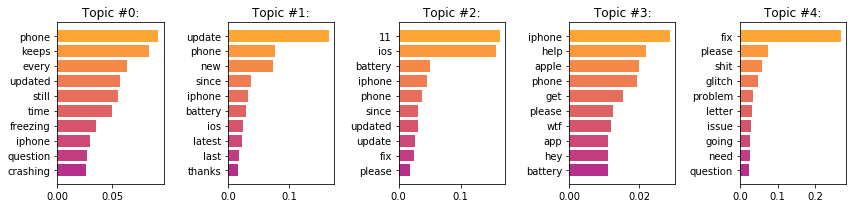

In [41]:
print_top_words(km.cluster_centers_, feature_names, n_top_words)
#for k, centroid in enumerate(km.cluster_centers_):
#    print("Cluster #%d:" % k)
#    print(" ".join([feature_names[i]
#                    for i in centroid.argsort()[:-n_top_words - 1:-1]]))
print_top_words_histo(km.cluster_centers_, feature_names, n_top_words)

## NMF - monogrammes

In [21]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=nb_of_topics,
          alpha=.1, l1_ratio=.5).fit(X)

Topic #0:
ios, 11, battery, iphone, life, since, 6s, updated, plus, draining
Topic #1:
fix, please, glitch, problem, issue, shit, going, gonna, hey, bug
Topic #2:
phone, update, new, since, updated, iphone, keeps, freezing, thanks, ever
Topic #3:
help, please, need, apple, iphone, hi, app, music, get, id
Topic #4:
shit, question, mark, letter, type, wtf, get, box, together, marks



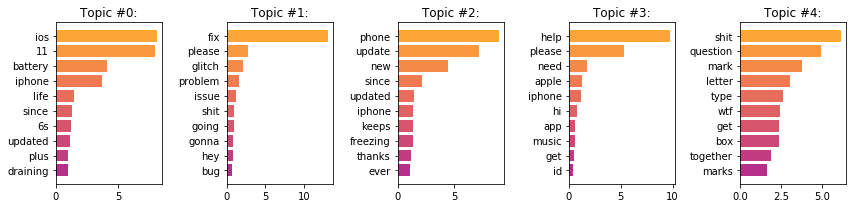

In [42]:
print_top_words(nmf.components_, vectorizer.get_feature_names(), n_top_words)
print_top_words_histo(nmf.components_, vectorizer.get_feature_names(), n_top_words)

## NMF - bigrammes

In [49]:
from sklearn.decomposition import NMF
nmf2 = NMF(n_components=nb_of_topics,
          alpha=.1, l1_ratio=.5).fit(X2)

Topic #0:
ios 11, 11 update, updated ios, battery life, 11 iphone, updating ios, since ios, iphone ios, iphone 6s, update ios
Topic #1:
please fix, fix glitch, fix problem, fix issue, dear please, fix bug, fix ios, fix asap, hey please, fix thing
Topic #2:
fix shit, need fix, gonna fix, yo fix, shit asap, better fix, needs fix, hey fix, shit already, question mark
Topic #3:
new update, update phone, since new, ever since, ios update, new ios, update sucks, battery life, phone keeps, update iphone
Topic #4:
please help, 11 please, hi please, help fix, iphone please, apple id, help thanks, update please, phone please, iphone 6s



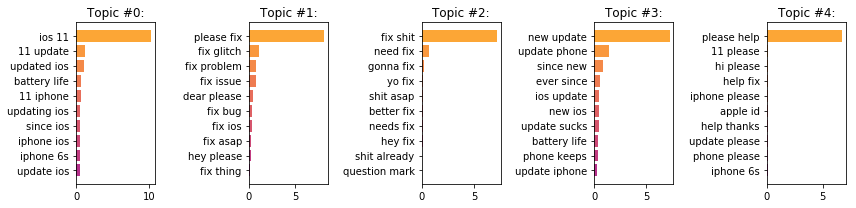

In [50]:
print_top_words(nmf2.components_, vectorizer2grams.get_feature_names(), n_top_words)
print_top_words_histo(nmf2.components_, vectorizer2grams.get_feature_names(), n_top_words)

In [44]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=10000,
                                stop_words=stopWords, token_pattern=tweet_regex)
X_tf = tf_vectorizer.fit_transform(apple.text_x)
lda = LatentDirichletAllocation(n_components=nb_of_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=2018)
t0 = time()
lda.fit(X_tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()


done in 51.329s.

Topics in LDA model:
Topic #0:
fix, please, music, problem, battery, ios, 11, issue, day, ios11
Topic #1:
phone, update, ios, iphone, 11, new, battery, since, updated, apps
Topic #2:
make, watch, hours, iphone, de, apple, seeing, boxes, someone, explain
Topic #3:
apple, help, iphone, phone, back, hi, get, please, app, new
Topic #4:
fix, screen, letter, use, question, working, time, get, type, app



Topic #0:
fix, please, music, problem, battery, ios, 11, issue, day, ios11
Topic #1:
phone, update, ios, iphone, 11, new, battery, since, updated, apps
Topic #2:
make, watch, hours, iphone, de, apple, seeing, boxes, someone, explain
Topic #3:
apple, help, iphone, phone, back, hi, get, please, app, new
Topic #4:
fix, screen, letter, use, question, working, time, get, type, app



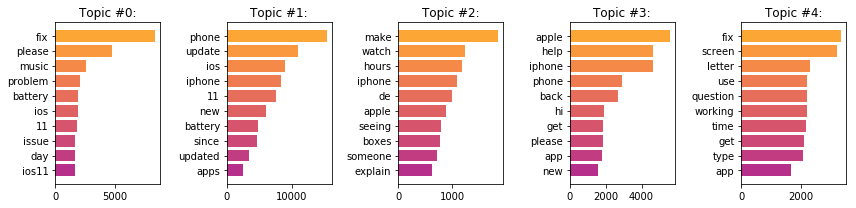

In [47]:
print_top_words(lda.components_, tf_feature_names, n_top_words)
print_top_words_histo(lda.components_, tf_feature_names, n_top_words)


In [26]:
apple[apple.text_x.str.contains('@115858') & apple.text_x.str.contains('t.co')].text_x

tweet_id
1758       Why is “I️” keep changing to this and how do I...
2611       Cupertino, we have a problem. .@115858 .@11633...
4908       コレは本当に困る、ゲームも出来なくなったしアップデートしなきゃ良かった´д` ;\n@App...
4914       Don’t complain a lot about @115858 but when ba...
5827       Heyyy @115858 still waiting on a version of iO...
6482       Hello @115858 @AppleSupport what’s happening t...
8543          what the fuck @115858? https://t.co/oHhvAW2pqh
8569       @115858 @AppleSupport FYI, Folders no longer s...
11109      My phone been fucking up all week @115858! htt...
11130      Is anyone doing bug fixing @115858  anymore? I...
11644      How do I get rid of this notification? @4305 @...
13212      Terror del siglo XXI!!! Ayúdame @115858 ! http...
13577      @115858 @AppleSupport buggie spotted https://t...
13589      Tudo bom ??? Todos estão com o mesmo problema ...
13930      This what happens to my iPhone after I downloa...
13934      I’m sorry but wtf is this @115858 https://t.co...
14333      .@Ap

In [27]:
from nltk.stem import WordNetLemmatizer
#import nltk
#nltk.download()
wordnet_lemmatizer = WordNetLemmatizer()
wordnet_lemmatizer.lemmatize('books',pos='n')

'book'

In [28]:
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer('english')
snowball_stemmer.stem('I think I should stick to buying books the ')
sentence = 'wtf is this @115858 https://t.co/1bxDR1xA0S'
" ".join([snowball_stemmer.stem(word) for word in sentence.split(" ")])
snowball_stemmer.stem('iphone')

'iphon'

In [29]:
print(apple.iloc[5].text_x)

Thank you @AppleSupport I updated my phone and now it is even slower and barely works. Thank you for ruining my phone.😤
